In [17]:
import tensorflow as tf
import numpy as np
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import argparse
import sys
import random

In [18]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1) # cuts off tails from normal distribution, keeps elements [-2,2] #
  #initial = tf.random_normal(shape, stddev=0.1) # cuts off tails from normal distribution, keeps elements [-2,2] #
  return tf.Variable(initial)

In [19]:
#####################################################################################
### Code by Lauren Hayward Sierens
#####################################################################################

from   itertools import product
import numpy as np
import random
from   scipy.optimize import fsolve

random.seed(111)

#       1 2 3 4 5 6 7 8 9 101112
dist= [[0,2,1,2,1,2,1,2,1,2,1,3], #1
       [2,0,2,2,1,1,2,2,1,1,3,1], #2
       [1,2,0,2,2,1,2,1,1,3,1,2], #3
       [2,2,2,0,2,2,1,1,3,1,1,1], #4
       [1,1,2,2,0,2,1,3,1,1,2,2], #5
       [2,1,1,2,2,0,3,1,1,2,2,1], #6
       [1,2,2,1,1,3,0,2,2,1,1,2], #7
       [2,2,1,1,3,1,2,0,2,2,1,1], #8
       [1,1,1,3,1,1,2,2,0,2,2,2], #9
       [2,1,3,1,1,2,1,2,2,0,2,1], #10
       [1,3,1,1,2,2,1,1,2,2,0,2], #11
       [3,1,2,1,2,1,2,1,2,1,2,0]] #12
dist = np.array(dist)

def incr_key(d,k):
  if d.get(k):
    d[k] += 1
  else:
    d[k] = 1

orbits={}

#Orbits with 0 or 12 points:
orbits[(0,())]  = 1
orbits[(12,())] = 1

#Orbits with 1 or 11 points:
orbits[(1,(0))] = 12
orbits[(11,(0))] = 12

#Orbits with 2 or 10 points:
for i1 in range(12):
  for i2 in range(i1+1, 12):
    key = (dist[i1,i2])
    incr_key(orbits, (2,key))
    incr_key(orbits,(10,key))

#Orbits with 3 or 9 points:
for i1 in range(12):
  for i2 in range(i1+1, 12):
    for i3 in range(i2+1, 12):
      key = tuple( sorted([ dist[i1,i2], dist[i1,i3], dist[i2,i3] ]) )
      incr_key(orbits, (3,key))
      incr_key(orbits,(9,key))

#Orbits with 4 or 8 points:
for i1 in range(12):
  for i2 in range(i1+1, 12):
    for i3 in range(i2+1, 12):
      for i4 in range(i3+1, 12):
        key = tuple( sorted([ dist[i1,i2], dist[i1,i3], dist[i1,i4], dist[i2,i3], dist[i2,i4], dist[i3,i4] ]) )
        incr_key(orbits,(4,key))
        incr_key(orbits,(8,key))

#Orbits with 5 or 7 points:
for i1 in range(12):
  for i2 in range(i1+1, 12):
    for i3 in range(i2+1, 12):
      for i4 in range(i3+1, 12):
        for i5 in range(i4+1, 12):
          key = tuple( sorted([ dist[i1,i2], dist[i1,i3], dist[i1,i4], dist[i1,i5],
                                             dist[i2,i3], dist[i2,i4], dist[i2,i5],
                                                          dist[i3,i4], dist[i3,i5],
                                                                       dist[i4,i5]]) )
          incr_key(orbits,(5,key))
          incr_key(orbits,(7,key))

#Orbits with 6 points:
for i1 in range(12):
  for i2 in range(i1+1, 12):
    for i3 in range(i2+1, 12):
      for i4 in range(i3+1, 12):
        for i5 in range(i4+1, 12):
          for i6 in range(i5+1, 12):
            key = tuple( sorted([ dist[i1,i2], dist[i1,i3], dist[i1,i4], dist[i1,i5], dist[i1,i6],
                                               dist[i2,i3], dist[i2,i4], dist[i2,i5], dist[i2,i6],
                                                            dist[i3,i4], dist[i3,i5], dist[i3,i6],
                                                                         dist[i4,i5], dist[i4,i6],
                                                                                      dist[i5,i6]]) )
            incr_key(orbits,(6,key))

#Now let's label the orbits. Also, create the function f:
N_orbits = len(orbits)
dict_keyToLabel = {} #new dictionary with the same keys, but arguments are the labels
i=0
for key in orbits.keys():
  dict_keyToLabel[key] = i
  i = i+1

lst = list(product([0, 1], repeat=12))
configs = np.array(lst)
raw_labels  = np.zeros(len(configs))

#Function to get the label corresponding to a given configuration:
def config_to_label(c):
  pts = [i for i in range(12) if c[i]==1]
  n = len(pts) #number of points
  
  if n>6:
    pts = [i for i in range(12) if c[i]==0]
  
  if n==0 or n==12:
    key = ()
  elif n==1 or n==11:
    key = (0)
  elif n==2 or n==10:
    key = (dist[pts[0],pts[1]])
  elif n==3 or n==9:
    key = tuple( sorted([ dist[pts[0],pts[1]], dist[pts[0],pts[2]], dist[pts[1],pts[2]] ]) )
  elif n==4 or n==8:
    key = tuple( sorted([ dist[pts[0],pts[1]], dist[pts[0],pts[2]], dist[pts[0],pts[3]],
                          dist[pts[1],pts[2]], dist[pts[1],pts[3]],
                          dist[pts[2],pts[3]] ]) )
  elif n==5 or n==7:
    key = tuple( sorted([ dist[pts[0],pts[1]], dist[pts[0],pts[2]], dist[pts[0],pts[3]], dist[pts[0],pts[4]],
                          dist[pts[1],pts[2]], dist[pts[1],pts[3]], dist[pts[1],pts[4]],
                          dist[pts[2],pts[3]], dist[pts[2],pts[4]],
                          dist[pts[3],pts[4]]]) )
  else: #n=6
    key = tuple( sorted([ dist[pts[0],pts[1]], dist[pts[0],pts[2]], dist[pts[0],pts[3]], dist[pts[0],pts[4]], dist[pts[0],pts[5]],
                          dist[pts[1],pts[2]], dist[pts[1],pts[3]], dist[pts[1],pts[4]], dist[pts[1],pts[5]],
                          dist[pts[2],pts[3]], dist[pts[2],pts[4]], dist[pts[2],pts[5]],
                          dist[pts[3],pts[4]], dist[pts[3],pts[5]],
                          dist[pts[4],pts[5]] ]) )

  return dict_keyToLabel[(n,key)]
#end config_to_label func

#This function converts an input config. (array) to a string (for file output):
def conf_to_str(c):
  s = ''
  for i in c:
    s = s + str(i)
  return s

#Loop over all configs to get all labels and write to file:
fout = open('config_labels.txt', 'w')
for (ic,c) in enumerate(configs):
  raw_labels[ic] = config_to_label(c)
  fout.write('%s \t %d \n' %(conf_to_str(c),raw_labels[ic]))
#end for
fout.close()

N = 2**12
px = 1.0/N

def psi(u,gam):
  return 1.0/ (1.0 + np.exp(-gam*u))

#Function that computes xlogx and gives 0 when x=0:
def xlogx(x):
  out = np.zeros(len(x))
  
  for i,xx in enumerate(x):
    if xx>1e-100:
     out[i] = xx*np.log2(xx)
  return out

#Function that fsolve will call:


In [4]:
## Preparing data ##
#configs = np.load('configs.npy') # Load data
num_configs=len(configs) # Total number of configurations
num_train_configs=1600
#num_train_configs=3480 # The percentage of configurations we're training with (85%) #
train_indices= random.sample(range(num_configs),num_train_configs) # select which configs we're using for training, i.e. this generates a vector with num_train_configs random numbers from range 0 to 4095
test_indices=[n for n in range(num_configs) if n not in train_indices] # the test indices are those not used for training

## Prepare CONFIGURATIONS ##
configs_train=np.array([configs[i] for i in train_indices])  # Prepare training configs
configs_test=np.array([configs[i] for i in test_indices])    # Prepare testing configs


## Prepare LABELS ##
theta = 39.5 # Threshold for dividing 64 orbits into two sets
labels = np.empty([4096,2]) # Create empty 4096 by 2 array for storing "hot" vector representation of the labels
labels[:,0]=np.heaviside([n-theta for n in raw_labels],0)    # If label > 34, store it as [1,0] == 1
labels[:,1]=1-np.heaviside([n-theta for n in raw_labels],0)  # If label <=34, store it as [0,1] ==0 
labels_train=np.array([labels[i] for i in train_indices])    # Prepare training labels
labels_test=np.array([labels[i] for i in test_indices])

In [5]:
print(sum(labels[:,1]))
print(sum(labels[:,0]))

2068.0
2028.0


In [ ]:
#x = tf.placeholder(tf.float32, shape=[None, 12]) # Inserts a placeholder for a tensor that will be always fed, 
                                                 # is fed using the feed_dict
    
#1st hidden layer
#W1 = weight_variable([12,10])       # Initiate the weight array from input layer to 1st hidden layer
#b1 = weight_variable([10])          # Initiate the 
#y1 = tf.tanh(tf.matmul(x,W1)+b1)
    
# 2nd hidden layer
#W2 = weight_variable([10,7])
#b2 = weight_variable([7])
#y2 = tf.tanh(tf.matmul(y1,W2)+b2)
    
# 3rd hidden layer
#W3 = weight_variable([7,5])
#b3 = weight_variable([5])
#y3 = tf.tanh(tf.matmul(y2,W3)+b3)
    
# 4th hidden layer
#W4 = weight_variable([5,4])
#b4 = weight_variable([4])
#y4 = tf.tanh(tf.matmul(y3,W4)+b4)
    
# 5th hidden layer
#W5 = weight_variable([4,3])
#b5 = weight_variable([3])
#y5 = tf.tanh(tf.matmul(y4,W5)+b5)
    
# 5th hidden layer
#W6 = weight_variable([3,2])
#b6 = weight_variable([2])
#y  = tf.matmul(y5,W6)+b6
    
# Define loss and optimizer
#y_ = tf.placeholder(tf.float32,[None,2])

In [6]:
x = tf.placeholder(tf.float32, shape=[None, 12]) # Inserts a placeholder for a tensor that will be always fed, 
                                                 # is fed using the feed_dict
    
#1st hidden layer
W1 = tf.Variable(tf.random_normal([12,10]))       # Initiate the weight array from input layer to 1st hidden layer
b1 = tf.Variable(tf.random_normal([10]))          # Initiate the 
y1 = tf.nn.tanh(tf.matmul(x,W1)+b1)
    
# 2nd hidden layer
W2 = tf.Variable(tf.random_normal([10,7]))
b2 = tf.Variable(tf.random_normal([7]))
y2 = tf.nn.tanh(tf.matmul(y1,W2)+b2)
    
# 3rd hidden layer
W3 = tf.Variable(tf.random_normal([7,5]))
b3 = tf.Variable(tf.random_normal([5]))
y3 = tf.nn.tanh(tf.matmul(y2,W3)+b3)
    
# 4th hidden layer
W4 = tf.Variable(tf.random_normal([5,4]))
b4 = tf.Variable(tf.random_normal([4]))
y4 = tf.nn.tanh(tf.matmul(y3,W4)+b4)
    
# 5th hidden layer
W5 = tf.Variable(tf.random_normal([4,3]))
b5 = tf.Variable(tf.random_normal([3]))
y5 = tf.nn.tanh(tf.matmul(y4,W5)+b5)
    
# 5th hidden layer
W6 = tf.Variable(tf.random_normal([3,2]))
b6 = tf.Variable(tf.random_normal([2]))
y  = tf.matmul(y5,W6)+b6
    
# Define loss and optimizer
y_ = tf.placeholder(tf.float32,[None,2])

In [ ]:
cross_entropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_, logits=y))  # Calculate the cross entropy (this tells us whether our network is actually learning)#
correct_prediction = tf.equal(tf.argmax(tf.sigmoid(y), 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Instructions on how to train our model
train_step = tf.train.GradientDescentOptimizer(0.1).minimize(cross_entropy)

# Begin training sessions
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
    
## Training parameters ##
minibatch_size = 20         # "Batching" the configuration is what introduces stochasticity into the network (this is a must!)#
num_epochs =600             # How many times do we run through the process and let our network learn

## Define arrays to collect accuracy and error data during training ##
err_list  = np.zeros(num_epochs)
train_acc = np.zeros(num_epochs)
test_acc = []

# add ops to save and restore all the variables.
saver = tf.train.Saver()

# reshuffle the data set in each epoch
permut = np.arange(num_train_configs)
    
for epoch in range(num_epochs):
    if (epoch%10==0):
        print(epoch)
    np.random.shuffle(permut)
    train_configs = configs_train[permut,:]
    train_labels = labels_train[permut,:]
    for k in range(0, num_train_configs, minibatch_size):
        batch_xs = train_configs[k:k+minibatch_size,:]
        batch_ys = train_labels[k:k+minibatch_size,:]
        sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})
        # for each epoch record one value of training accuracy and cross entropy
        if k==minibatch_size:
            train_acc[epoch] = accuracy.eval(feed_dict={x: batch_xs, y_: batch_ys})   
            err_list[epoch] = sess.run(cross_entropy, feed_dict={x: batch_xs, y_: batch_ys})
    # for every 10th epoch record the test accuracy
    if epoch%10==0:
        test_acc += [sess.run(accuracy, feed_dict={x: configs_test, y_: labels_test})]
    
    # save the variables to disk
    save_path = saver.save(sess, "/Users/tibraali/Documents/Machine Learning - Winter School/Python Codes/Data/toy_network_model_%i.ckpt".format(epoch))
    #save_path = saver.save(sess, "/Users/tibraali/Desktop/toy_network_model.ckpt")
    #print("Model saved in file: %s" % save_path)
    
# save arrays with accuracy and error data
np.savez_compressed('{}epochs_train_acc'.format(num_epochs), a=train_acc)
np.savez_compressed('{}epochs_test_acc'.format(num_epochs), a=test_acc)
np.savez_compressed('{}epochs_err_list'.format(num_epochs), a=err_list)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310


minibatch size = 20
number of epoches = 600
test accuracy final epoch = 0.863381


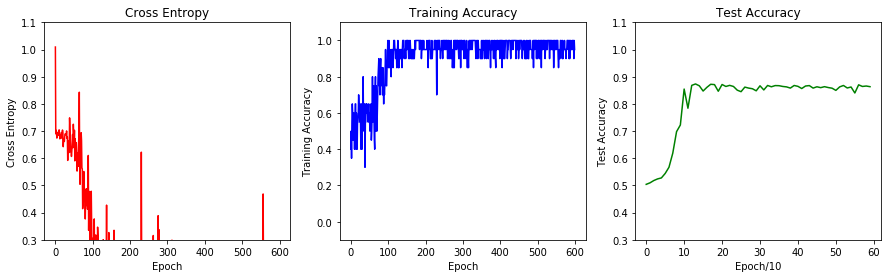

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

# load the data
err_list = np.load('{}epochs_err_list.npz'.format(num_epochs))['a']
train_acc = np.load('{}epochs_train_acc.npz'.format(num_epochs))['a']
test_acc = np.load('{}epochs_test_acc.npz'.format(num_epochs))['a']

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(np.arange(num_epochs), err_list, color='r')
plt.title('Cross Entropy')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.ylim([0.3, 1.1])


plt.subplot(1,3,2)
plt.plot(np.arange(num_epochs), train_acc, color='b')
plt.title('Training Accuracy')
plt.ylabel('Training Accuracy')
plt.xlabel('Epoch')
plt.ylim([-0.1, 1.1])

plt.subplot(1,3,3)
plt.plot(np.arange(num_epochs/10), test_acc, color='g')
plt.title('Test Accuracy')
plt.ylabel('Test Accuracy')
plt.xlabel('Epoch/10')
plt.ylim([0.3, 1.1])

print("minibatch size = %d" %minibatch_size)
print("number of epoches = %d" %num_epochs)
print("test accuracy final epoch = %f" %test_acc[-1])

In [29]:
correct_prediction = tf.equal(tf.argmax(tf.sigmoid(y), 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(sess.run(accuracy, feed_dict={x: configs_test, y_: labels_test}))

0.8697917
